# Monte Carlo Simulations

## Loading Packages

In [1]:
using Dates, Statistics, Random, LinearAlgebra, Distributions

include("jlFiles/printmat.jl")
include("jlFiles/NWFn.jl")
include("jlFiles/OlsFn.jl")

OlsFn

In [2]:
using Plots

backend = "gr"              #"gr" (default), "pyplot" 

if backend == "pyplot"
    pyplot(size=(600,400))
else    
    gr(size=(480,320))
    default(fmt = :svg)
end

# Simulating the Distribution of a GARCH(1,1) Variable

The next cell defines a function that generates $T$ observations of a variable $u$ by assuming that the conditional distribution (based on information in $t-1$) is N$(0,\sigma_t^2)$, where $\sigma_t^2$ follows a GARCH(1,1) process:

$
\sigma_{t}^{2}    =\omega+\alpha u_{t-1}^{2}+\beta\sigma_{t-1}^{2}.
$

In [3]:
function GarchSim(T,ω,α,β)

    (σ²,u) = [zeros(T) for i=1:2]
    σ²[1]  = ω/(1-α-β)                              #average σ² as starting value
    for t = 2:T
        σ²[t] = ω + α*u[t-1]^2 + β*σ²[t-1]
        u[t]  = sqrt(σ²[t])*randn()
    end
    
    return u
    
end    

GarchSim (generic function with 1 method)

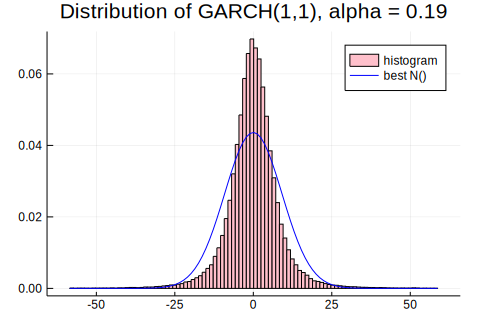

In [4]:
(T,ω,α,β) = (200_000,1,0.19,0.8)                #α=0.19

u = GarchSim(T,ω,α,β)

(qL,qH) = quantile(u,[0.001,0.999])             #quantiles 0.001 and 0.999

uGrid = range(qL,stop=qH,length=101)
pdfNu = pdf.(Normal(mean(u),std(u)),uGrid)

p1 = histogram(u,bins=uGrid,color=:pink,normalized=true,label="histogram")
plot!(uGrid,pdfNu,color=:blue,label="best N()")
title!("Distribution of GARCH(1,1), alpha = $α")

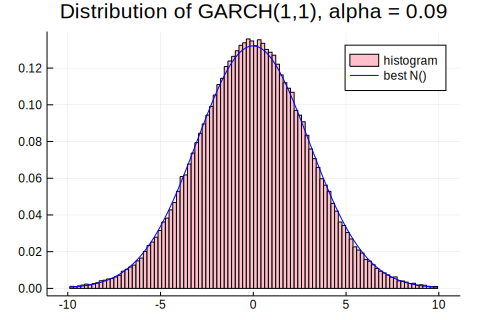

In [5]:
α = 0.09                                            #α=0.09

u = GarchSim(T,ω,α,β)

(qL,qH) = quantile(u,[0.001,0.999])                 

uGrid = range(qL,stop=qH,length=101)
pdfNu = pdf.(Normal(mean(u),std(u)),uGrid)

p1 = histogram(u,bins=uGrid,color=:pink,normalized=true,label="histogram")
plot!(uGrid,pdfNu,color=:blue,label="best N()")
title!("Distribution of GARCH(1,1), alpha = $α")

# Simulating (White's) Heteroskedasticity in OLS



In [6]:
function SimOLS(NSim,T,α)
    
    Random.seed!(1234567)
    (bLS,StdLS,StdWhite) = [fill(NaN,NSim) for i = 1:3]
    for i = 1:NSim
        f = randn(T)
        ϵ = randn(T) .* (1 .+ α*abs.(f))
        y = 1 .+ 0.9*f + ϵ
        x = [f ett]
        (b,u,_,Covb,) = OlsFn(y,x,0)           #OLS, White's
        bLS[i]        = b[1]
        StdWhite[i]   = sqrt(Covb[1,1]/T)
        CovbLS_i      = inv(x'x)*var(u)        #OLS, traditional
        StdLS[i]      = sqrt(CovbLS_i[1,1])
    end

    return bLS,StdLS,StdWhite

end

SimOLS (generic function with 1 method)

In [7]:
NSim = 25000          
T    = 200             
ett  = ones(T)


α = 1
(bLS,StdLS,StdWhite) = SimOLS(NSim,T,α)

xut = [std(bLS) mean(StdLS) mean(StdWhite)]
println("Std of slope, when α=$α")
println("Simulated      OLS       White")
printmat(xut)


α = 0
(bLS,StdLS,StdWhite) = SimOLS(NSim,T,α)

xut = [std(bLS) mean(StdLS) mean(StdWhite)]
println("Std of slope, when α=$α")
println("Simulated      OLS       White")
printmat(xut)

Std of slope, when α=1
Simulated      OLS       White
     0.189     0.134     0.185

Std of slope, when α=0
Simulated      OLS       White
     0.071     0.071     0.070

